In [1]:
## importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [43]:
## importing the dataset
data = pd.read_csv('map_data.csv',index_col='id',usecols=['id','Latitude','Longitude'])

In [44]:
## sample data
data.head()

,Longitude,Latitude
id,,
1,-99.711318,32.470813
2,-99.711345,32.467800
3,-99.704908,32.470813
4,-99.705004,32.467800
5,-99.711200,32.468212


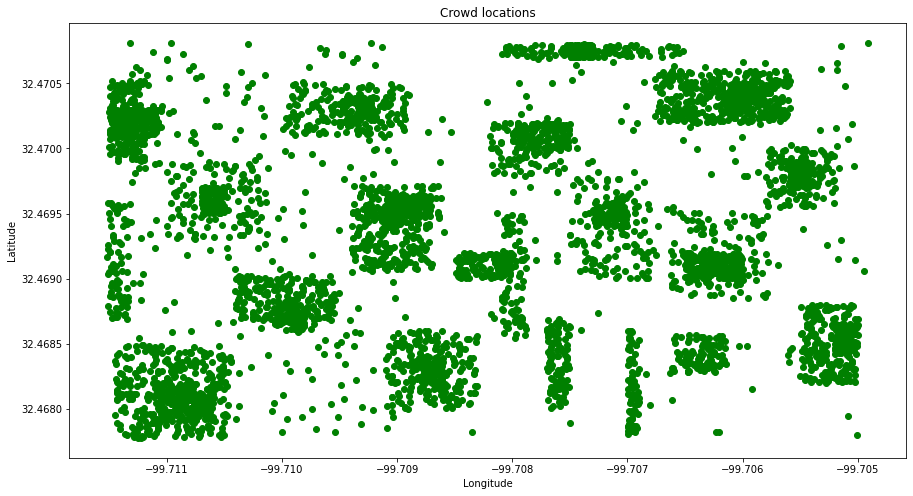

In [11]:
## plotting the locations
plt.figure(figsize=(15,8))
plt.scatter(data=data,x='Longitude',y='Latitude',color='green')
plt.title('Crowd locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [45]:
## Performing K-Means clustering
## importing the KMeans library
from sklearn.cluster import KMeans

## initializing the Kmeans with 16 clusters
km = KMeans(n_clusters=16)

## Fitting the model for dataset
data['cluster'] = km.fit_predict(data)

In [46]:
data

,Longitude,Latitude,cluster
id,,,
1,-99.711318,32.470813,4
2,-99.711345,32.467800,2
3,-99.704908,32.470813,1
4,-99.705004,32.467800,8
5,-99.711200,32.468212,2
...,...,...,...
5030,-99.705574,32.469844,1
5031,-99.705543,32.469733,1
5032,-99.705517,32.469862,1


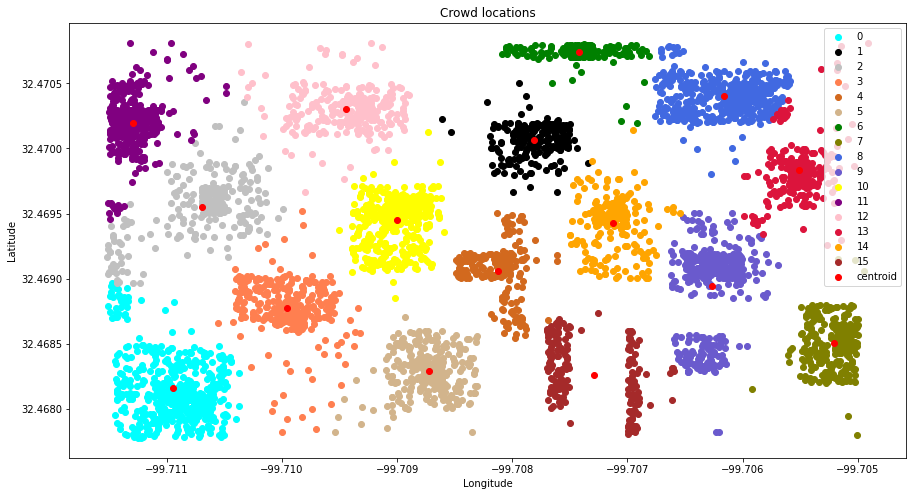

In [18]:
## Fixing the size of the plot
plt.figure(figsize=(15,8))

## fixing the color for clusters
colors = ['aqua','black','silver','coral','chocolate','tan','green','olive','royalblue','slateblue','yellow',
          'purple','pink','crimson','orange','brown']

## plotting the clusters 
for i in range(0,16):
    plt.scatter(data.Longitude[data.cluster==i] , data.Latitude[data.cluster==i] , label = i,color=colors[i])

## Plotting the centroid of the clusters
plt.scatter(x=km.cluster_centers_[:,0],y=km.cluster_centers_[:,1],color='red',label='centroid')
plt.title('Crowd locations')
plt.xlabel('Longitude')
plt.legend()
plt.ylabel('Latitude')
plt.show()

In [19]:
## creating the dataset to apply timestamping
## creating the empty library
timestamp = pd.DataFrame()

## selecting the 60 records from each cluster
for i in range(0,16):
    timestamp = timestamp.append(data[data.cluster==i].head(60))
    
## exporting the data
timestamp.to_csv('cluster_data.csv')

In [20]:
## reading the timestamp data
t_data = pd.read_csv('cluster_data.csv')
t_data.head()

,id,Longitude,Latitude,cluster,Timestamp_1,Timestamp_2
0,34,-99.708632,32.469896,0,15,8
1,137,-99.709036,32.468973,0,15,8
2,145,-99.709222,32.469616,0,15,8
3,146,-99.708591,32.469361,0,15,8
4,1225,-99.708716,32.469525,0,15,8


In [21]:
x=[];y=[]
for i in range(0,len(t_data)):
    x.append([t_data.cluster[i],t_data.Timestamp_1[i]])
    y.append([t_data.Timestamp_1[i],t_data.Timestamp_2[i]])

In [22]:
## importing the libraries to train LSTM model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [23]:
## padding the input and output values
x = pad_sequences(x,maxlen=3)
y = pad_sequences(y,maxlen=3)

In [24]:
## creating the training dataset
train_data = tf.data.Dataset.from_tensor_slices((x,y))

In [29]:
## initializing the model
model = Sequential()

model.add(LSTM(64, activation='relu', input_shape=(None,3), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu',name='Hidden'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='softmax',name='Output'))

opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, None, 64)          17408     
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
Hidden (Dense)               (None, 32)                4128      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
Output (Dense)               (None, 16)               

In [30]:
## Fitting for train data
model.fit(x,y, epochs=3,batch_size=32)

Epoch 1/3


ValueError: ignored

Not able to train the model, as not able to solve the error

***Plotting movement of a person based on the distance to the cluster***

In [31]:
## defining a function to plot the test person location
image = plt.imread('map.png')
def locate_me(point):
    plt.figure(figsize=(20,12))
    plt.imshow(image,extent=[-99.7116,-99.704908,32.4676,32.4709])    ##fixing size of the graph
    plt.scatter(data=data,x='Longitude',y='Latitude',color='yellow',label='Crowd location')
    plt.scatter(x=point[0], y=point[1],color='red',marker='*',s=200,label='Person Location')
    plt.title('Crowd')
    plt.xlabel('Longitude')
    plt.legend()
    plt.ylabel('Latitude')
    plt.show()

In [47]:
## Defining a function to track the person movement based on distance to the cluster
def movement(point):
    z = km.predict([point])   ## mapping new location with the cluster
    point1 = km.cluster_centers_[int(z)]    ## centroid of the mapped cluster
    dx = (point1[0]-point[0])*0.8
    dy = (point1[1]-point[1])*0.8
    plt.figure(figsize=(20,12))
    plt.imshow(image,extent=[-99.7116,-99.704908,32.4676,32.4709])
    plt.scatter(data=data,x='Longitude',y='Latitude',color='yellow',label='Crowd location')     ## plotting the crowd locations
    plt.scatter(x=point[0], y=point[1],color='red',marker='*',s=300,label='Person Location')    ## plotting the person previous location
    plt.scatter(x=point1[0], y=point1[1],color='red',marker='+',s=300,label='New Location')    ## plotting the person new location
    plt.arrow(point[0],point[1],dx,dy,width=0.000008,head_width=0.00007,label='movement')
    plt.title('Crowd')
    plt.xlabel('Longitude')
    plt.legend()
    plt.ylabel('Latitude')
    plt.show()
    plt.show()

In [48]:
## test point
point = [-99.7085, 32.470]

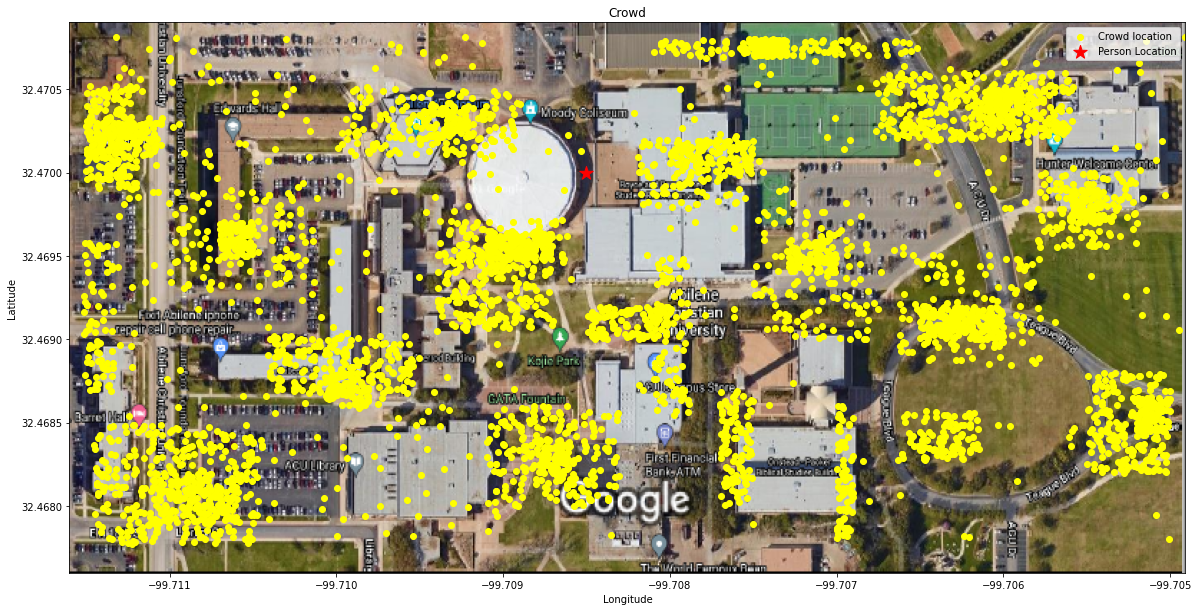

In [49]:
## checking the location
locate_me(point)

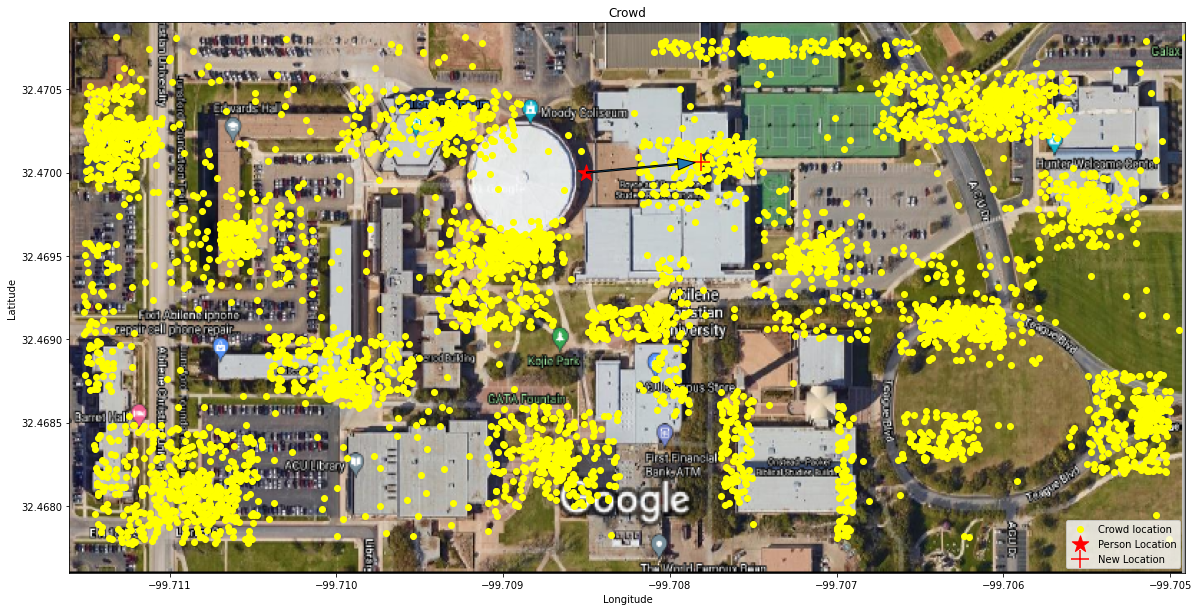

In [50]:
## Predicting the movement of the person
movement(point)